In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from network import Network
from perceptron import Perceptron
from layer import Layer
from tqdm import tqdm
import typing as tp
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score



In [45]:
def reset_rc():
    sns.set_theme()
    sns.set_theme(rc={'figure.figsize': (8.25, 5.875), 'figure.dpi': 100, 'axes.labelpad': 2, 'savefig.pad_inches': .5})

In [46]:
reset_rc()

In [2]:
df: pd.DataFrame = pd.read_csv(os.path.join('data', 'group_project_data.csv'))
df

,Data Item,LAC,SOW,TACA
0,1,0.90,0.87,1
1,2,1.81,1.02,0
2,3,1.31,0.75,1
3,4,2.36,1.60,0
4,5,2.48,1.14,0
5,6,2.17,2.08,1
6,7,0.41,1.87,0
7,8,2.85,2.91,1
8,9,2.45,0.52,0
9,10,1.05,1.93,0


<Axes: xlabel='TACA', ylabel='count'>

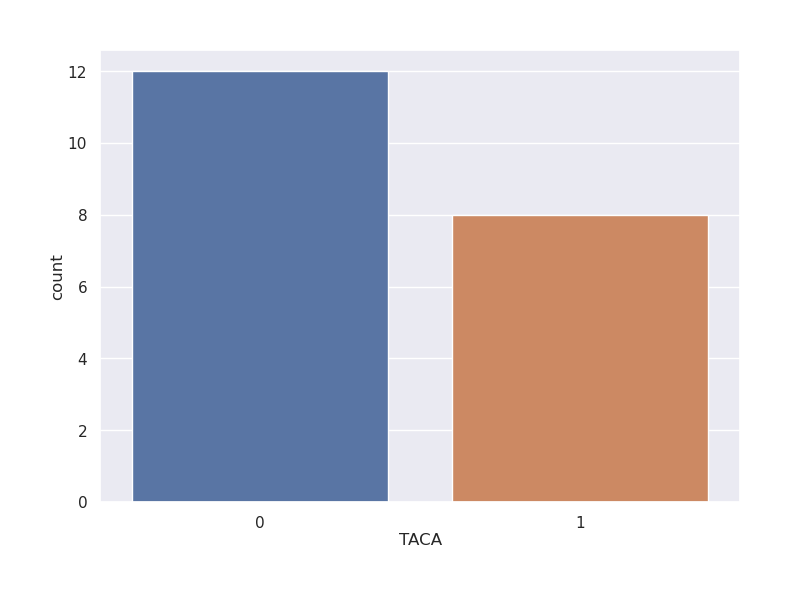

In [51]:
sns.countplot(data=df, x='TACA')

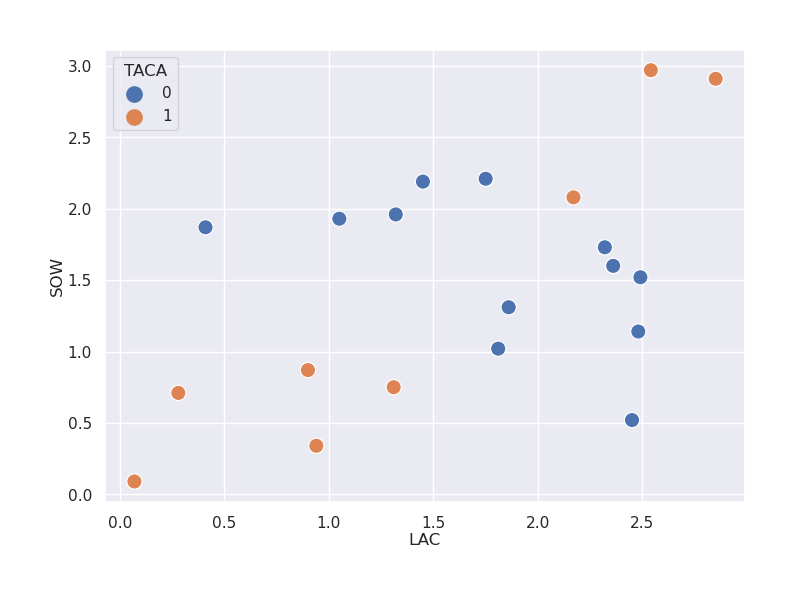

In [50]:
sns.set_context(rc={'lines.markersize': 11})
sns.scatterplot(data=df, x='LAC', y='SOW', hue='TACA')
reset_rc()

In [3]:
def min_max_scale(a: np.ndarray) -> np.ndarray:
    min_val: np.ndarray = np.min(a, axis=0)
    max_val: np.ndarray = np.max(a, axis=0)
    return (a - min_val) / (max_val - min_val)

def get_average_error(net: Network, x: np.ndarray, y: np.ndarray) -> float:
    tot_error: float = 0
    for i in range(x.shape[0]):
        net.feedforward(x[i])
        tot_error += net.get_total_error(y[i])
    return tot_error

In [4]:
x_cols: tp.List[str] = ['LAC', 'SOW']
y_cols: tp.List[str] = ['TACA']

all_x: np.ndarray = df[x_cols].values 
all_y: np.ndarray = df[y_cols].values 

train_x: np.ndarray = all_x[::2]
train_y: np.ndarray = all_y[::2]

test_x: np.ndarray = all_x[1::2]
test_y: np.ndarray = all_y[1::2]

train_x.shape, train_y.shape

((10, 2), (10, 1))

In [5]:
def do_single_data(_net: Network, x: np.ndarray, y: np.ndarray, learning_rate: float, threshold_f: tp.Callable[[float], bool],
                   do_training: bool = True) -> tp.Tuple[Network, bool, float]:
    net: Network = deepcopy(_net)
    curr_out: np.ndarray = net.feedforward(x)
    if do_training:
        net.backprop(learning_rate, y)
    prediction: bool = threshold_f(curr_out.item())
    return net, prediction, curr_out.item()

In [6]:
def schedule_lr(curr_epoch: int, base_lr: float, max_num_epochs: int, normalizer: float = 0.25, error_diff: tp.Optional[float] = None) -> float:
    # increase lr if it's early in the training, but decrease it from the base_lr if it's late in training.
    p_epoch: float = float(curr_epoch // 10)
    halfway_p: float = float(max_num_epochs // 20)
    # If p_epoch is low, then d_epoch will be high, and cause the output learning rate to be higher.
    d_epoch: float = halfway_p - p_epoch
    
    if error_diff is not None:
        # If our error difference is small or not decreasing, 
        # then we want to boost the learning rate a good bit.
        # But if the error is large or increasing,
        # then we want to not increase the learning rate. 
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            error_modifier: float = np.abs(np.log10(error_diff))
        if np.isinf(error_modifier):
            error_modifier: float = 5
        if error_modifier > 3 or error_diff >= 0:
            last_d_epoch: float = d_epoch
            d_epoch += (error_modifier - 3) ** 2
            # print(f'{last_d_epoch=} to {d_epoch=} / {error_modifier=} / {error_diff=}')
    
    out_lr: float = (10 ** d_epoch) * base_lr * normalizer
    
    if len(f'{out_lr:.0f}') > 2:
        out_lr = normalizer * 100 
    return out_lr

In [7]:
def train_network(_net: Network, x: np.ndarray, y: np.ndarray, n_epochs: int, learning_rate: float, threshold_f: tp.Callable[[float], bool]) -> \
        tp.Tuple[Network, tp.List[tp.Dict[str, tp.Any]]]:
    net: Network = deepcopy(_net)
    results: tp.List[tp.Dict[str, tp.Any]] = []

    last_error: tp.Optional[float] = None 
    error_difference: tp.Optional[float] = None 

    for epoch in range(n_epochs):
        predictions: tp.List[float] = []
        curr_lr: float = schedule_lr(epoch, learning_rate, n_epochs, error_diff=error_difference)
        # print(f'{curr_lr=}')
        for i in range(x.shape[0]):
            net, pred = do_single_data(net, x[i, :], y[i, :], curr_lr, threshold_f)[:-1]
            predictions.append(pred)
        
        if last_error is not None:
            last_error: float = curr_error    
        curr_error: float = get_average_error(net, x, y)
        if last_error is not None:
            error_difference: float = curr_error - last_error
        if last_error is None:
            last_error: float = curr_error
        
        
        f1: float = f1_score(y_pred=np.array(predictions), y_true=y)
        results.append({'epoch': epoch, 'error': curr_error, 'f1_score': f1, 'lr': curr_lr})
    return net, results

In [8]:
def get_network(use_biases: bool, num_hidden_nodes: int) -> Network:
    out_net: Network = (Network()
                        .add_layer(Layer(num_in_features=2, num_out_features=num_hidden_nodes, is_hidden_layer=True, use_biases=use_biases))
                        .add_layer(Layer(num_in_features=num_hidden_nodes, num_out_features=1, is_hidden_layer=False, use_biases=use_biases)))
    return out_net

In [9]:
def get_custom_network(use_biases: bool, num_hidden_layers: int) -> Network:
    out_net: Network = Network()
    num_in: int = 2
    for i in range(num_hidden_layers):
        num_out: int = int(2 ** (np.log2(num_in) + 1))
        out_net = out_net.add_layer(Layer(num_in_features=num_in,
                                          num_out_features=num_out,
                                          is_hidden_layer=True,
                                          # initial_weights=[np.array([0.86362921, 0.45834485]), np.array([0.21442937, 0.37422296])],
                                          use_biases=use_biases))
        num_in = num_out

    while num_in > 2:
        num_out: int = int(2 ** (np.log2(num_in) - 1))
        out_net = out_net.add_layer(Layer(num_in_features=num_in, num_out_features=num_out, is_hidden_layer=True, use_biases=use_biases))
        num_in: int = num_out

    out_net = out_net.add_layer(
        Layer(num_in_features=2,
              num_out_features=1,
              is_hidden_layer=False,
              # initial_weights=[np.array([0.48372709, 0.00577109])],
              use_biases=use_biases))
    return out_net

In [10]:
# train_network(get_custom_network(True, 2), train_x, train_y, 100, 1e-4, lambda data: data >= 0.4)

In [11]:
lr: float = 1e-3
threshold: tp.Callable[[float], bool] = lambda f: f >= 0.6

In [12]:
def do_kfold_training(_net: Network, num_folds: int = 3, n_epochs: int = 40, threshold_f: tp.Optional[tp.Callable[[float], bool]] = None) -> tp.Tuple[pd.DataFrame, tp.Dict[int, tp.Tuple[Network, float]]]:
    net: Network = deepcopy(_net)
    k_fold_obj: KFold = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    if threshold_f is None:
        threshold_f: tp.Callable[[float], bool] = lambda data: data >= 0.5

    analysis_results: tp.List[pd.DataFrame] = []

    network_results: tp.Dict[int, tp.Tuple[Network, float]] = {}

    for fold_idx, (train_indices, test_indices) in enumerate(k_fold_obj.split(train_x, train_y)):
        c_trained_network, c_fold_results = train_network(net, train_x[train_indices, :], train_y[train_indices], n_epochs, lr, threshold)
        current_fold_results: pd.DataFrame = pd.DataFrame.from_records(c_fold_results)
        current_fold_results['fold_num'] = fold_idx

        c_test_predictions: tp.List[bool] = [do_single_data(c_trained_network, train_x[ti, :], train_y[ti], lr, threshold_f, do_training=False)[1]
                                           for ti in test_indices]
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            c_test_f1_score: float = f1_score(train_y[test_indices], y_pred=np.array(c_test_predictions).astype(int))
        current_fold_results['test_f1'] = c_test_f1_score
        
        # if not all(not np.allclose(original_perceptron.weights, trained_perceptron.weights) for original_layer, trained_layer in zip(net.layers, c_trained_network.layers) for original_perceptron, trained_perceptron in zip(original_layer.perceptrons, trained_layer.perceptrons)):
        #     print(f'Hey just FYI apparently your network is not getting updated at {fold_idx=}/{n_epochs=}')

        network_results[fold_idx] = (c_trained_network, c_test_f1_score)

        analysis_results.append(current_fold_results)
    return pd.concat(analysis_results), network_results

In [13]:
def test_network(net: Network, threshold_val: float) -> tp.Tuple[float, float]:
    best_threshold_f: tp.Callable[[float], bool] = lambda d: d >= threshold_val

    y_pred: np.ndarray = np.array([do_single_data(net, test_x[test_i, :], test_y[test_i], 0, best_threshold_f, False)[1] for test_i in range(test_x.shape[0])])

    return f1_score(y_pred=y_pred, y_true=test_y), roc_auc_score(test_y, y_pred)

In [14]:
from itertools import product 

In [15]:
grid_search_results: tp.Dict[bool, tp.Dict[int, tp.Dict[int, tp.Tuple[Network, float]]]] = {}

grid_search_dfs: tp.List[pd.DataFrame] = []

use_bias_values: tp.List[bool] = [True, False]
hidden_layer_values: tp.List[int] = list(range(1, 16 + 1))
epoch_values: tp.List[int] = list(range(30, 181, 10))
threshold_values: tp.List[float] = np.arange(0.3, 0.91, 0.05).tolist()

config_values: tp.List = list(product(use_bias_values, hidden_layer_values, epoch_values, threshold_values))

network_results: tp.List[tp.Tuple[int, bool, int, int, float, Network, float]] = []

for use_bias, hidden_nodes, epochs, threshold_limit in tqdm(config_values):
    threshold_function: tp.Callable[[float], bool] = lambda data: data >= threshold_limit
    np.random.seed(13)
    custom_network: Network = get_network(use_bias, hidden_nodes)
    
    # if epochs == 30 and use_bias:
    #     print(str(custom_network))
        
    grid_search_df, net_results = do_kfold_training(custom_network, n_epochs=epochs, threshold_f=threshold_function)
    
    grid_search_df['use_bias'] = use_bias
    grid_search_df['num_hidden_nodes'] = hidden_nodes
    grid_search_df['num_epochs'] = epochs
    grid_search_df['threshold'] = threshold_limit
    
    grid_search_dfs.append(grid_search_df)
    network_results.extend([(fold, use_bias, hidden_nodes, epochs, threshold_limit, given_network, f1_score_num) for fold, (given_network, f1_score_num) in net_results.items()])
search_df: pd.DataFrame = pd.concat(grid_search_dfs)
search_df

100%|██████████| 6656/6656 [3:11:24<00:00,  1.73s/it]  


,epoch,error,f1_score,lr,fold_num,test_f1,use_bias,num_hidden_nodes,num_epochs,threshold
0,0,1.524317,0.500000,2.500000e-03,0,0.857143,True,1,30,0.3
1,1,1.523681,0.500000,2.500000e-03,0,0.857143,True,1,30,0.3
2,2,1.523043,0.500000,2.500000e-03,0,0.857143,True,1,30,0.3
3,3,1.522404,0.500000,2.500000e-03,0,0.857143,True,1,30,0.3
4,4,1.521764,0.500000,2.500000e-03,0,0.857143,True,1,30,0.3
...,...,...,...,...,...,...,...,...,...,...
175,175,1.500000,0.727273,2.500000e-08,2,0.500000,False,16,180,0.9
176,176,1.500000,0.727273,2.500000e-08,2,0.500000,False,16,180,0.9
177,177,1.500000,0.727273,2.500000e-08,2,0.500000,False,16,180,0.9
178,178,1.500000,0.727273,2.500000e-08,2,0.500000,False,16,180,0.9


In [16]:
search_df.describe()

,epoch,error,f1_score,lr,fold_num,test_f1,num_hidden_nodes,num_epochs,threshold
count,2.096640e+06,2.096640e+06,2.096640e+06,2.096640e+06,2.096640e+06,2.096640e+06,2.096640e+06,2.096640e+06,2.096640e+06
mean,6.211905e+01,1.279611e+00,3.735624e-01,4.985837e+00,1.000000e+00,2.977536e-01,8.500000e+00,1.252381e+02,6.000000e-01
std,4.334481e+01,5.311726e-01,3.647903e-01,9.827175e+00,8.164968e-01,3.277000e-01,4.609773e+00,4.141763e+01,1.870829e-01
min,0.000000e+00,4.346710e-03,0.000000e+00,2.500000e-12,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+01,3.000000e-01
25%,2.600000e+01,8.079492e-01,0.000000e+00,2.500000e-06,0.000000e+00,0.000000e+00,4.750000e+00,9.750000e+01,4.500000e-01
50%,5.500000e+01,1.196792e+00,4.000000e-01,2.500000e-03,1.000000e+00,0.000000e+00,8.500000e+00,1.300000e+02,6.000000e-01
75%,9.300000e+01,1.980994e+00,7.272727e-01,2.500000e+00,2.000000e+00,5.000000e-01,1.225000e+01,1.600000e+02,7.500000e-01
max,1.790000e+02,2.000000e+00,1.000000e+00,9.908669e+01,2.000000e+00,1.000000e+00,1.600000e+01,1.800000e+02,9.000000e-01


In [17]:
final_search_df: pd.DataFrame = search_df.query('epoch == (num_epochs - 1)').copy()
final_search_df.describe()

,epoch,error,f1_score,lr,fold_num,test_f1,num_hidden_nodes,num_epochs,threshold
count,19968.000000,19968.000000,19968.000000,1.996800e+04,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000
mean,104.000000,1.273314,0.419829,3.260522e-02,1.000000,0.342004,8.500000,105.000000,0.600000
std,46.098877,0.512110,0.352764,9.015430e-01,0.816517,0.327893,4.609888,46.098877,0.187088
min,29.000000,0.004347,0.000000,2.500000e-12,0.000000,0.000000,1.000000,30.000000,0.300000
25%,66.500000,0.839347,0.000000,2.500000e-08,0.000000,0.000000,4.750000,67.500000,0.450000
50%,104.000000,1.280588,0.500000,2.500000e-07,1.000000,0.500000,8.500000,105.000000,0.600000
75%,141.500000,1.596698,0.727273,2.500000e-06,2.000000,0.500000,12.250000,142.500000,0.750000
max,179.000000,2.000000,1.000000,2.500000e+01,2.000000,1.000000,16.000000,180.000000,0.900000


In [18]:
# for use_bias, hidden_nodes, epochs, threshold_limit in tqdm(config_values)
best_network: tp.Tuple[Network, float, float, bool, int, int, int] = (Network(), -10.0, -10.0, False, -100, -100, -100) 
for us_bias, hh_nodes, es, th_lim in tqdm(config_values, desc='Finding best network'):
    list_of_values: tp.List[tp.Tuple[Network, float]] = [(net, f1_score_for_net) for _, using_bias, h_nodes, e, t_lim, net, f1_score_for_net in network_results if using_bias == us_bias and e == es and th_lim == t_lim and h_nodes == hh_nodes]
    # Network, f1, roc
    test_metrics: tp.List[tp.Tuple[Network, float, float]] = [(net, m[0], m[1]) for net, _ in list_of_values if len(m := test_network(net, th_lim)) > 0]
    best_of_curr: tp.Tuple[Network, float, float] = max(test_metrics, key=lambda m: m[2])
    if best_network[2] < best_of_curr[2]:
        best_network = best_of_curr[0], best_of_curr[1], best_of_curr[2], us_bias, hh_nodes, es, th_lim
best_network: tp.Dict[str, tp.Union[int, bool, float, Network]] = {'network': best_network[0], 'f1_score': best_network[1], 'auc_roc': best_network[2], 'use_bias': best_network[3], 'hidden_nodes': best_network[4], 'num_epochs': best_network[5], 'threshold_limit': best_network[6]}
best_network

Finding best network: 100%|██████████| 6656/6656 [01:34<00:00, 70.35it/s]


{'network': [
 	(0) :: Layer(in=2, out=7, is_hidden=True, use_biases=False)
 	(1) :: Layer(in=7, out=1, is_hidden=False, use_biases=False)
 ],
 'f1_score': 0.8,
 'auc_roc': 0.8333333333333333,
 'use_bias': False,
 'hidden_nodes': 7,
 'num_epochs': 40,
 'threshold_limit': 0.8999999999999999}

In [23]:
from sklearn.metrics import roc_curve, RocCurveDisplay

In [22]:
y_prob: tp.List[float] = [do_single_data(best_network['network'], test_x[i, :], test_y[i, :], 0, threshold_f=lambda t: t >= best_network['threshold_limit'], do_training=False)[-1] for i in range(test_x.shape[0])]
roc_curve(y_true=test_y, y_score=y_prob)

(array([0., 0., 0., 1., 1.]),
 array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ]),
 array([       inf, 0.91005213, 0.90013448, 0.88135048, 0.83443659]))

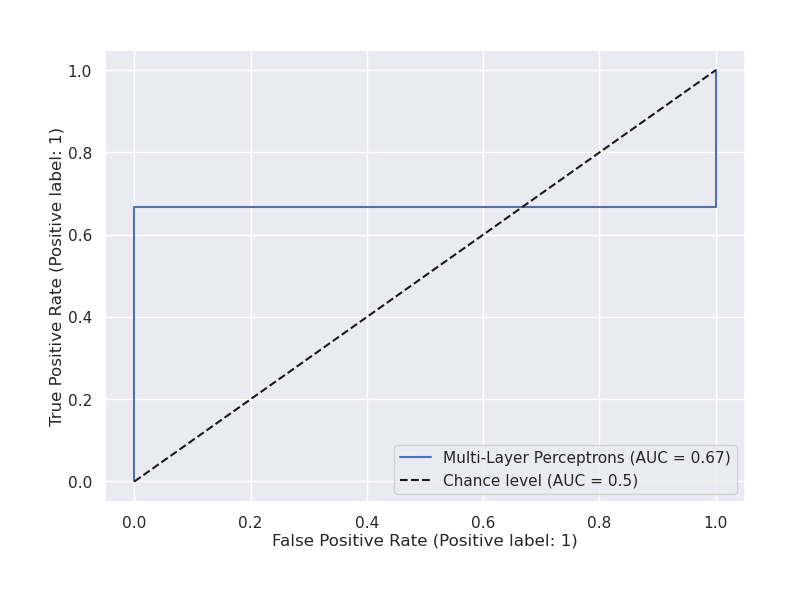

In [27]:
RocCurveDisplay.from_predictions(y_pred=y_prob, y_true=test_y, plot_chance_level=True, name='Multi-Layer Perceptrons')

Text(0.5, 0, 'F1 Score (higher is better)')

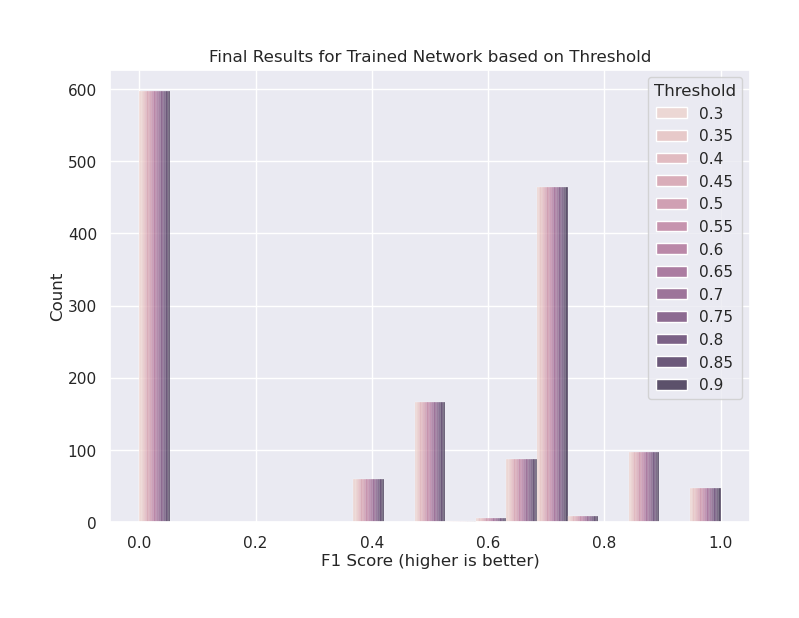

In [33]:
final_search_df['Threshold'] = final_search_df['threshold'].apply(lambda d: float(f'{d:.2f}'))
sns.histplot(data=final_search_df, x='f1_score', hue='Threshold', multiple='dodge')
plt.title('Final Results for Trained Network based on Threshold')
plt.xlabel('F1 Score (higher is better)')

Text(0.5, 0, 'F1 Score')

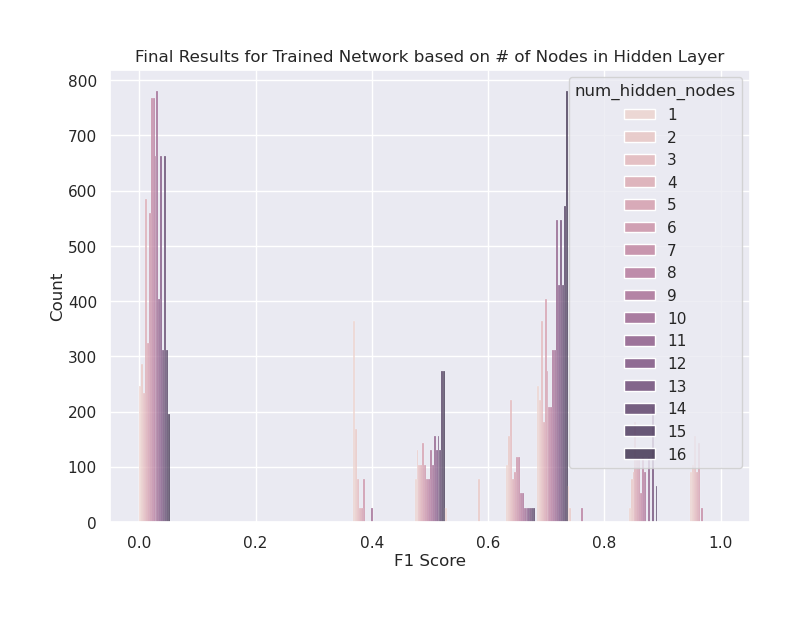

In [32]:
sns.histplot(data=final_search_df, x='f1_score', hue='num_hidden_nodes', multiple='dodge')
plt.title('Final Results for Trained Network based on # of Nodes in Hidden Layer')
plt.xlabel('F1 Score')

Text(0.5, 0, 'F1 Score')

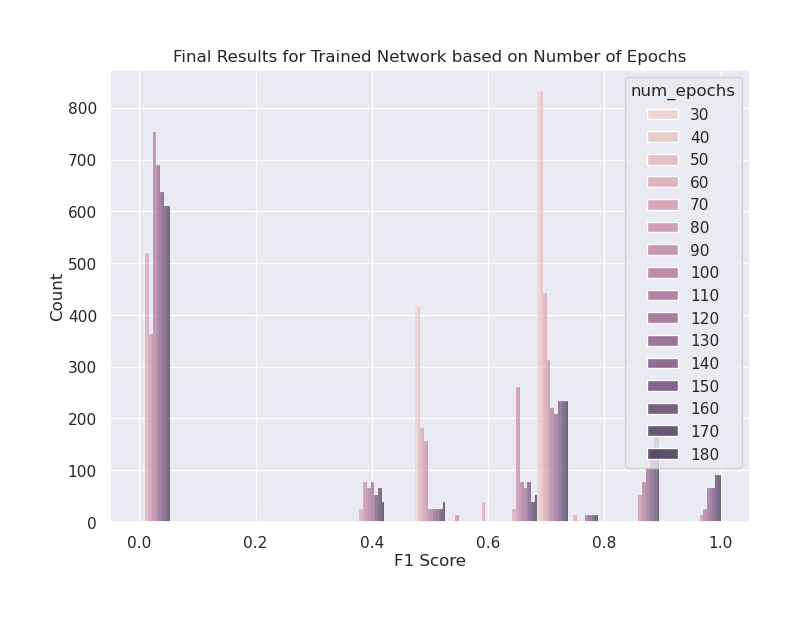

In [30]:
sns.histplot(data=final_search_df, x='f1_score', hue='num_epochs', multiple='dodge')
plt.title('Final Results for Trained Network based on Number of Epochs')
plt.xlabel('F1 Score')

In [ ]:
sns.histplot(data=final_search_df, x='f1_score', hue='fold_num', multiple='dodge')
plt.title('Final Results for Trained Network based on Fold Number')
plt.xlabel('F1 Score')

In [ ]:
final_search_df.groupby(['num_epochs', 'num_hidden_nodes', 'threshold', 'use_bias']).aggregate({'f1_score': ['min', 'mean', np.median, 'max']})  # .reset_index().groupby([('f1_score', 'median')]).max()
# [('f1_score', 'median')] # .sort_values(('f1_score', 'max'), axis=1)

In [ ]:
# "","",0.7,False

chosen_config: tp.Dict[str, tp.Union[int, bool, float]] = {'num_epochs': 90, 'num_hidden_nodes': 7, 'threshold': 0.4, 'use_bias': False}
# network_results.extend([(fold, use_bias, hidden_nodes, epochs, threshold_limit, given_network, f1_score_num)
[(net, f1_score_for_net) for _, using_bias, h_nodes, e, t_lim, net, f1_score_for_net in network_results if using_bias == chosen_config['use_bias'] and e == chosen_config['num_epochs'] and chosen_config['threshold'] == t_lim and h_nodes == chosen_config['num_hidden_nodes']][0]

In [ ]:
actual_best_network: Network = best_network[0]


In [ ]:
sns.scatterplot(data=search_df, x='epoch', y='f1_score', hue='num_hidden_nodes')

In [ ]:
sns.scatterplot(data=search_df, x='epoch', y='f1_score', hue='threshold')

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
help(roc_auc_score)